# Calculate reference stress for each temperature at each strain rate

For each condition, calculate take the stress where strain is smaller than 0.08 and divide it by the reference stress at 298.15K

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [15]:
ref_temp = '298.15'

#First set, comment out second set to generate for this one
strain_rates = [0.0001]
temps = ['77.15', '233.15']

#Second set
strain_rates = [0.0001, 0.001, 0.01, 0.1]
temps = ['373.15', '473.15', '573.15', '673.15']

#Third set
strain_rates = [0.0001, 0.001, 0.01, 0.1,1]
temps = ['298.15']


for temp in temps:
    # Initialize DataFrame with strain column for the current temperature
    df = None  # Initialize df to None to handle it dynamically for each temperature
    
    for strain_rate in strain_rates:
        # Load stress data for the current temperature and strain rate
        data_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')
        
        if df is None:
            # Initialize DataFrame with strain column if not already done
            df = pd.DataFrame({'strain': data_RD['Strain']})
        
        # Add stress data for the current strain rate as a new column
        df[f'StrR{strain_rate}'] = data_RD['Stress']

    # Filter the DataFrame for strain values below 0.08
    df = df[df['strain'] < 0.08]
    
    # Save the DataFrame to a CSV file for the current temperature
    output_file_path = f"Tmp{temp}_RD.csv"
    df.to_csv(output_file_path, index=False)


# Find parameters for strain rate function

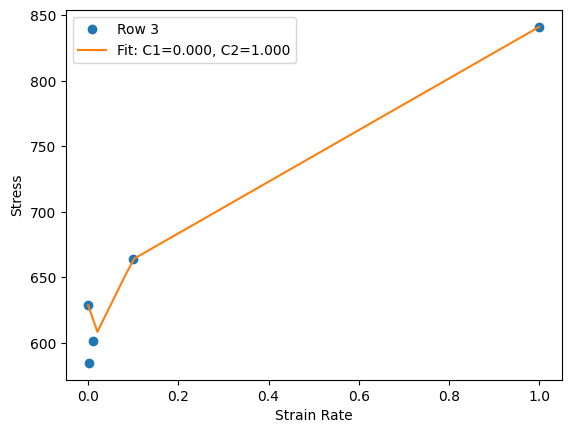

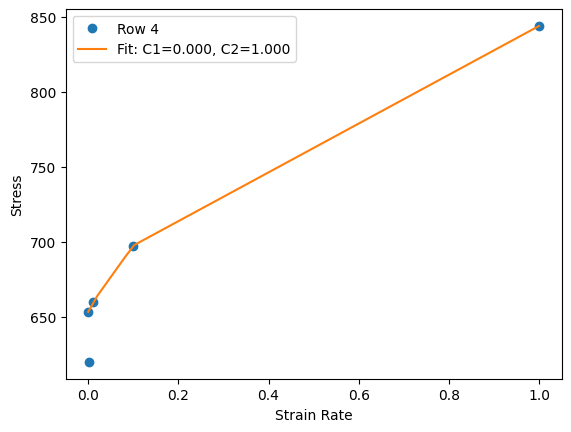

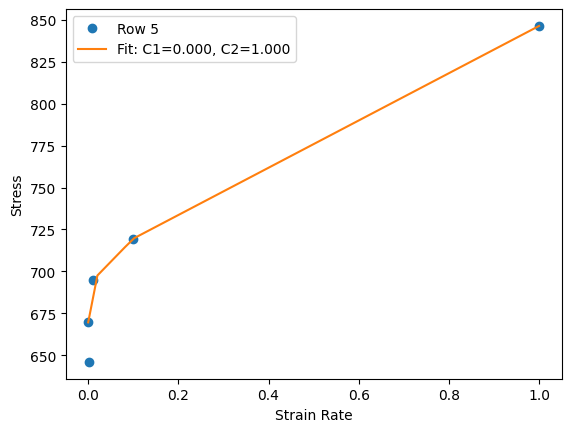

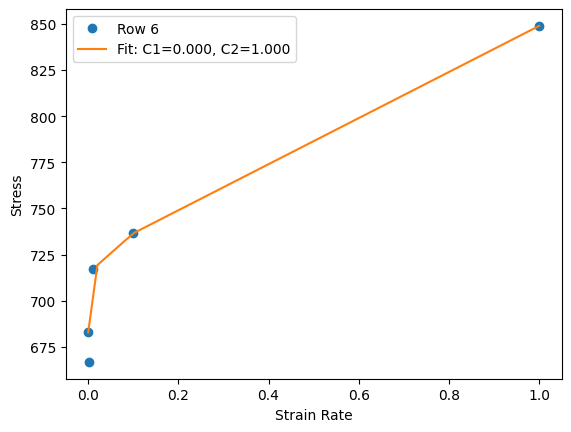

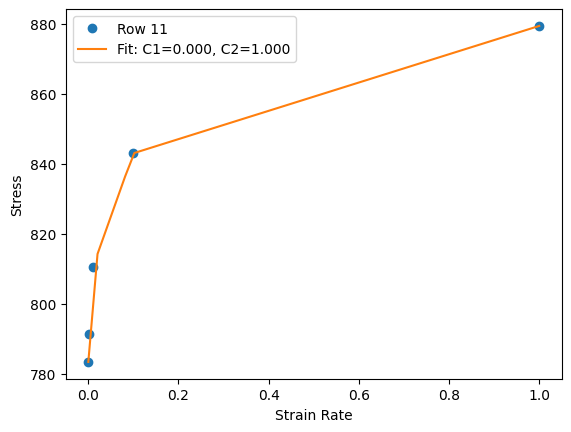

In [32]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

# Load the temperature-specific file to access data
temp_file_path = 'Tmp298.15_RD.csv'  # Update path if necessary
data = pd.read_csv(temp_file_path)

# Define strain rates corresponding to the columns in the file
strain_rate_columns = ['StrR0.0001', 'StrR0.001', 'StrR0.01', 'StrR0.1', 'StrR1']
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]  # Actual strain rate values corresponding to the columns

# Define the strain-rate dependency function without a static representative stress
def strain_rate_dependent_stress(strain_rate, C1, C2, stress_values):
    # Ensure stress_values is an array with the same length as strain_rate for direct multiplication
    return np.array([s * (C1 * np.log(sr) + C2) for s, sr in zip(stress_values, strain_rate)])

# Now perform the strain-rate dependency fitting directly using the provided stress data
# Loop through specified strains (rows in the data) for strain-rate dependency fitting
indices = [3, 4, 5, 6, 11]  # Example rows in the file to process

for i in indices:
    # Extract stress data for the specified strain rates at row `i`
    stress_values = data.iloc[i, 1:].values  # Select all columns except the first (strain)
    plastic_strain = data['strain'].iloc[i]  # Get the plastic strain at this row

    # Fit strain-rate dependency with evolving stress values
    initial_guess_sr = [0.1, 1]  # Adjusted initial guesses
    bounds_sr = ([0, 0], [np.inf, np.inf])  # Tighter bounds to avoid non-physical values
    
    # Perform the curve fitting for strain-rate dependency using evolving stress values
    try:
        params_sr, _ = curve_fit(lambda sr, C1, C2: strain_rate_dependent_stress(sr, C1, C2, stress_values),
                                 strain_rates, stress_values, p0=initial_guess_sr, bounds=bounds_sr)
    except RuntimeError:
        print(f"Could not fit strain-rate dependency for row {i}")
        continue
    
    # Generate data for the fit curve
    strain_rate_fit = np.linspace(min(strain_rates), max(strain_rates), 50)
    stress_fit = strain_rate_dependent_stress(strain_rate_fit, *params_sr, np.interp(strain_rate_fit, strain_rates, stress_values))
    
    # Plot the original data and the fitted curve
    plt.plot(strain_rates, stress_values, 'o', label='Data')
    plt.plot(strain_rate_fit, stress_fit, '-', label='Fit')
    plt.xlabel('Strain Rate')
    plt.ylabel('Stress')
    plt.legend([f'Row {i}', f'Fit: C1={params_sr[0]:.3f}, C2={params_sr[1]:.3f}'])
    plt.show()


# Bonus

Temperature dependence

In [ ]:
ref_temp = '298.15'

#First set, comment out second set to generate for this one
strain_rates = [0.0001]
temps = ['77.15', '233.15', '298.15', '373.15', '473.15', '573.15', '673.15']

#Second set
strain_rates = [0.001, 0.01, 0.1]
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

for strain_rate in strain_rates:
    # Load reference stress data at 298.15 K for the given strain rate
    data_RD_ref = pd.read_csv(f'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    ref_stress_RD = data_RD_ref['Stress']  # Stress column at reference temperature
    
    # Initialize DataFrame with strain column
    df = pd.DataFrame({'strain': data_RD_ref['Strain']})
    
    # Loop over each temperature to calculate and add normalized stress columns
    for temp in temps:
        # Load stress data at the current temperature
        temp_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        # Calculate normalized stress by dividing by reference stress at 298.15 K
        normalized_stress_RD = temp_RD / ref_stress_RD
        
        # Add normalized stress as a column in the DataFrame
        df[f'Tmp{temp}K_ref'] = normalized_stress_RD

    # Save the DataFrame to a CSV file
    df = df[df['strain'] < 0.08]
    output_file_path = f"StrainRate{strain_rate}_RD.csv"
    df.to_csv(output_file_path, index=False)